# DistilBert fine-tuning

- 1. Task: 

- 2. 더 해볼 과제:

- 3. 특이 사항:


## [My Code] Data Load


### [My Code] Model Config

In [23]:
import torch
# 모델 config입니다.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = "distilbert-base-uncased"
ds_name = "nyu-mll/glue"
ds_config = "mnli"

n_labels = 3

test_size = 0.5
random_state = 42
batch_size = 64
max_len = 400

results_dir = './results/week4_basic'
lr = 2e-5
n_epochs = 10

### [My Code] Load Data and split it into Train, Val, Test

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
import pandas as pd

# Parquet 형태의 데이터셋입니다.
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=n_labels)
model = model.to(device)
raw_dataset = load_dataset(ds_name, ds_config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
import torch
from torchinfo import summary
# 모델 정보 출력
# 더미 입력 데이터
vocab_size = len(tokenizer)
dummy_input_ids = torch.randint(0, vocab_size, (batch_size, max_len))  # 랜덤한 input_ids
dummy_attention_mask = torch.ones(batch_size, max_len, dtype=torch.int64)  # attention_mask: 모든 값이 1

# 모델 요약 출력
print("Model Summary")
print("Vocab_size ", vocab_size)
print("Input Shape ", dummy_input_ids.shape)
print("Attention_Mask Shape ", dummy_attention_mask.shape)
print(summary(model, input_data={"input_ids": dummy_input_ids.to(device), "attention_mask": dummy_attention_mask.to(device)}))

Model Summary
Vocab_size  30522
Input Shape  torch.Size([64, 400])
Attention_Mask Shape  torch.Size([64, 400])
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 3]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            23,440,896
│    │    └─Embedding: 3-2                              [1, 400, 768]             393,216
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            1,536
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 

In [30]:
for param in model.distilbert.parameters():
    param.requires_grad = False

print("Model Summary")
print("Vocab_size ", vocab_size)
print("Input Shape ", dummy_input_ids.shape)
print("Attention_Mask Shape ", dummy_attention_mask.shape)
print(summary(model, input_data={"input_ids": dummy_input_ids.to(device), "attention_mask": dummy_attention_mask.to(device)}))

Model Summary
Vocab_size  30522
Input Shape  torch.Size([64, 400])
Attention_Mask Shape  torch.Size([64, 400])
Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 3]                   --
├─DistilBertModel: 1-1                                  [64, 400, 768]            --
│    └─Embeddings: 2-1                                  [64, 400, 768]            --
│    │    └─Embedding: 3-1                              [64, 400, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 400, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 400, 768]            --
│    └─Transformer: 2-2                                 [64, 400, 768]            --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─

In [37]:
def tokenize(batch, max_len):

  return tokenizer(
    batch["premise"],
    batch['hypothesis'],
    padding="max_length",
    max_length = max_len,
    truncation="longest_first" ,
    return_tensors = 'pt')

# ds = raw_dataset['train']
ds = raw_dataset['train'].select(range(1000))
ds = ds.map(lambda batch: tokenize(batch, max_len), batched=True)

In [38]:
from datasets import DatasetDict


train_test_split = ds.train_test_split(test_size=0.1)
test_data = train_test_split['test']
train_data = train_test_split['train']
train_val_split = train_data.train_test_split(test_size=0.3333)
train_data = train_val_split['train']
val_data = train_val_split['test']

dataset_dict = {
    'train': train_data,
    'val': val_data,
    'test': test_data,
}

dataset = DatasetDict(dataset_dict)
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 600
    })
    val: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [39]:
# sample을 확인하는 함수입니다. 
def sample_check(type, num):

    print("Sample_Idx: ", dataset[type]['idx'][num], end="\n\n")

    print("Sample_label: ", dataset[type]['label'][num], end="\n\n")

    print("Sample_premise ", dataset[type]['premise'][num], end="\n\n")

    print("Sample_hypothesis: ", dataset[type]['hypothesis'][num], end="\n\n")

sample_check(type = 'train', num = 3)

Sample_Idx:  409

Sample_label:  0

Sample_premise  Dave Hanson, to whom nothing is impossible, he said.

Sample_hypothesis:  He said Dave Hanson.



### [My Code] 텍스트 길이 분포 계산


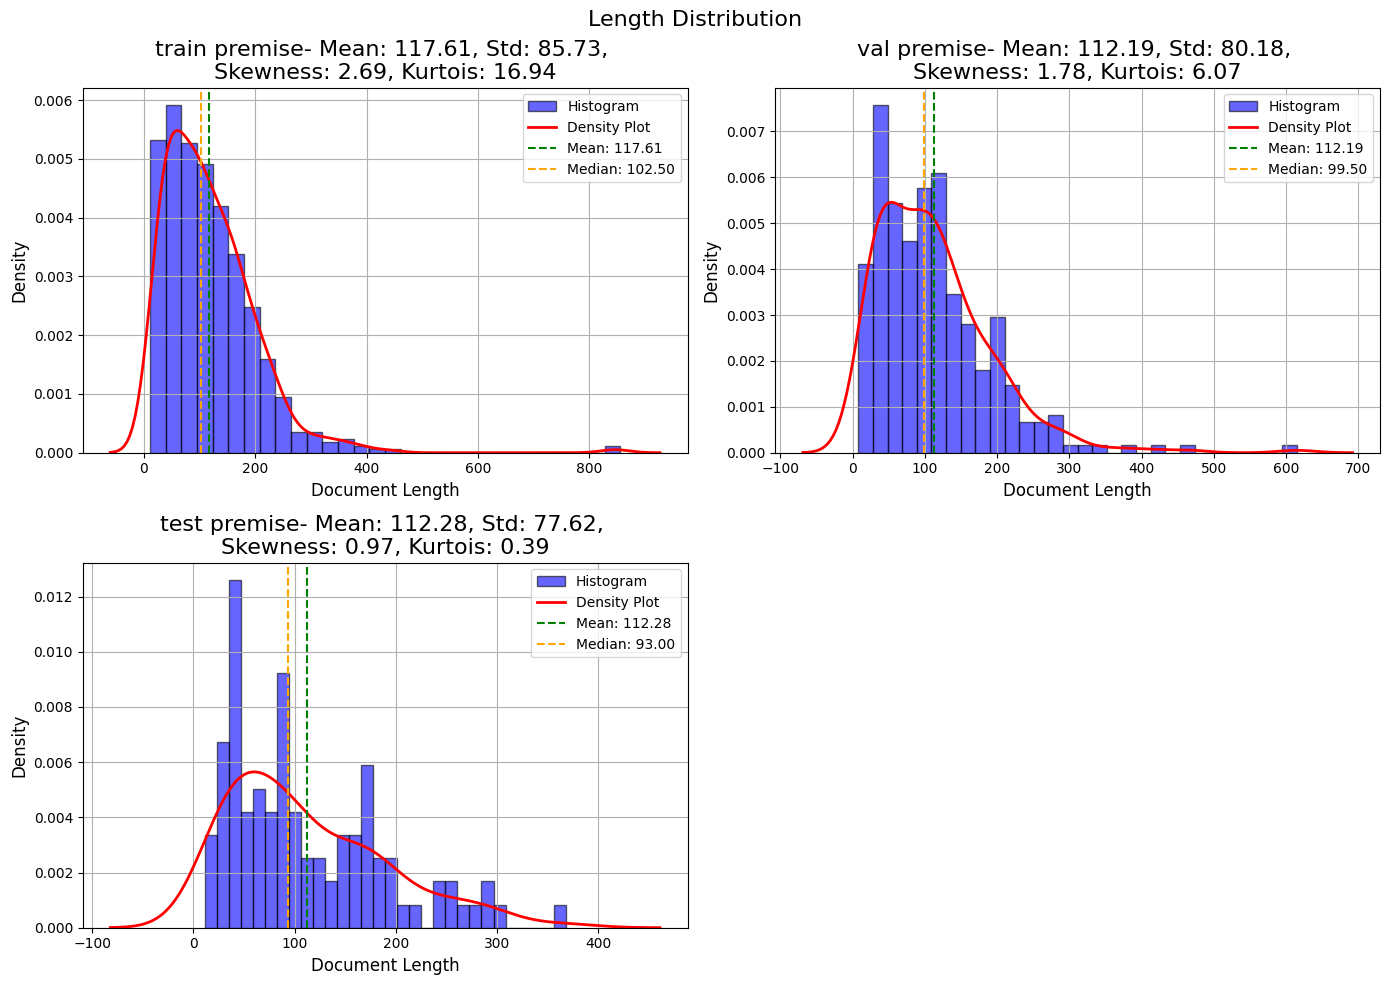

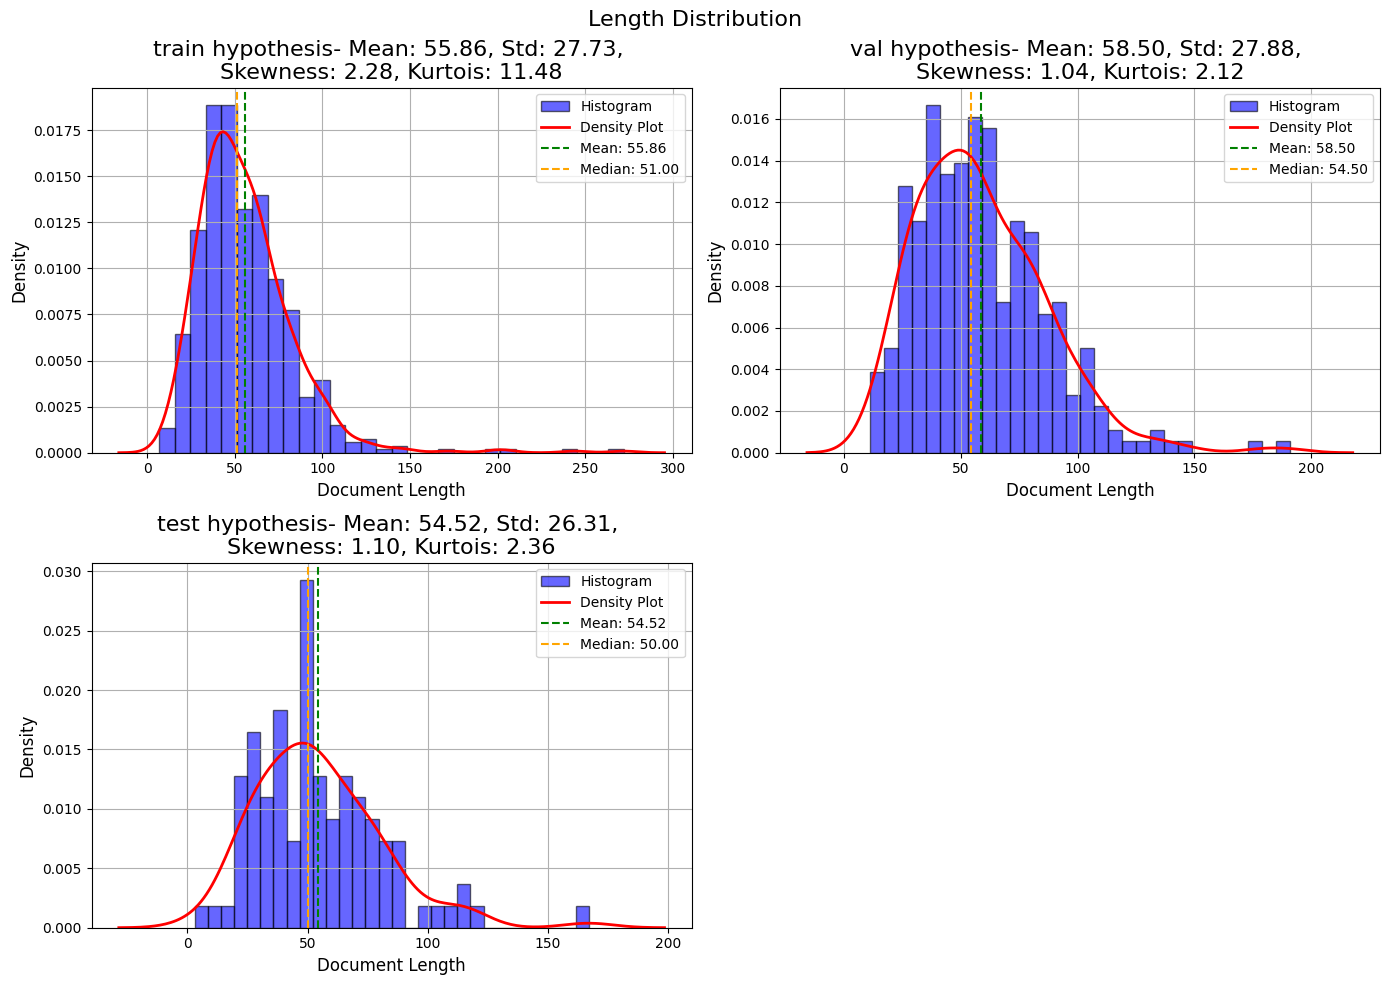

In [40]:
# 평균, 표준편차, 왜도, 첨도 계산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

def final_plotting(type):
    plt.figure(figsize=(14,10))
    for i, name in enumerate(['train', 'val', 'test']):
        plt.subplot(2,2,i+1)
        length_plot([len(data)for data in dataset[name][type]], name+" "+type)
    plt.suptitle("Length Distribution", fontsize=16)
    plt.tight_layout()
    plt.show()

final_plotting('premise')

final_plotting('hypothesis')

### 1.4 [My Code] Label Distribution

In [41]:
# text: a string feature.
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.DataFrame(
    [
        pd.Series(dataset['train']['label']).value_counts(normalize=True).sort_index(),
        pd.Series(dataset['val']['label']).value_counts(normalize=True).sort_index(),
        pd.Series(dataset['test']['label']).value_counts(normalize=True).sort_index(),
    ],
    index = ['train','val','test'],
)

display(df)

,0,1,2
train,0.331667,0.306667,0.361667
val,0.350000,0.253333,0.396667
test,0.390000,0.220000,0.390000


## [My Code] Training

In [42]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [63]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 합니다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(predictions, labels)
    f1 = f1_score(predictions, labels, average="weighted")
    precision = precision_score(predictions, labels, average="weighted")
    recall = recall_score(predictions, labels, average="weighted")
    return {
        'accuracy': accuracy, 
        'f1': f1, 
        'precision': precision, 
        'recall': recall
        }

training_args = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=n_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none"
)

In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

In [68]:
# 테스트 데이터셋에 대한 예측과 평가를 진행합니다.
initial_test_metrics = trainer.predict(test_dataset=dataset["test"])
initial_metrics = initial_test_metrics.metrics
print(f"Test Metrics:", "\n", 
      "loss: ", initial_metrics['test_loss'], "\n", 
      "accuracy: ", initial_metrics['test_accuracy'], "\n", 
      "f1:", initial_metrics['test_f1'], "\n", 
      "precision: ", initial_metrics['test_precision'], "\n", 
      "recall:", initial_metrics['test_recall']      
      )

Test Metrics: 
 loss:  1.0681555271148682 
 accuracy:  0.43 
 f1: 0.45375337533753374 
 precision:  0.5252564102564102 
 recall: 0.43


In [65]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.071300,1.081388,0.420000,0.516167,0.808002,0.420000
2,1.070000,1.079569,0.433333,0.482177,0.602205,0.433333
3,1.074200,1.076189,0.430000,0.484692,0.605627,0.430000
4,1.073600,1.075121,0.430000,0.482219,0.590400,0.430000
5,1.072100,1.075664,0.433333,0.481328,0.597174,0.433333
6,1.066400,1.075678,0.433333,0.479964,0.605356,0.433333
7,1.066900,1.075527,0.436667,0.483479,0.609666,0.436667
8,1.060500,1.075225,0.433333,0.475686,0.592492,0.433333
9,1.062400,1.075230,0.433333,0.474505,0.584998,0.433333
10,1.066300,1.075240,0.436667,0.477565,0.583465,0.436667


TrainOutput(global_step=100, training_loss=1.0683652687072753, metrics={'train_runtime': 76.2918, 'train_samples_per_second': 78.645, 'train_steps_per_second': 1.311, 'total_flos': 620952004800000.0, 'train_loss': 1.0683652687072753, 'epoch': 10.0})

## [My Code] Metric Plotting

In [69]:
# 테스트 데이터셋에 대한 예측과 평가를 진행합니다.
test_metrics = trainer.predict(test_dataset=dataset["test"])
metrics = test_metrics.metrics
print(f"Test Metrics:", "\n", 
      "loss: ", metrics['test_loss'], "\n", 
      "accuracy: ", metrics['test_accuracy'], "\n", 
      "f1:", metrics['test_f1'], "\n", 
      "precision: ", metrics['test_precision'], "\n", 
      "recall:", metrics['test_recall']      
      )

Test Metrics: 
 loss:  1.0681555271148682 
 accuracy:  0.43 
 f1: 0.45375337533753374 
 precision:  0.5252564102564102 
 recall: 0.43


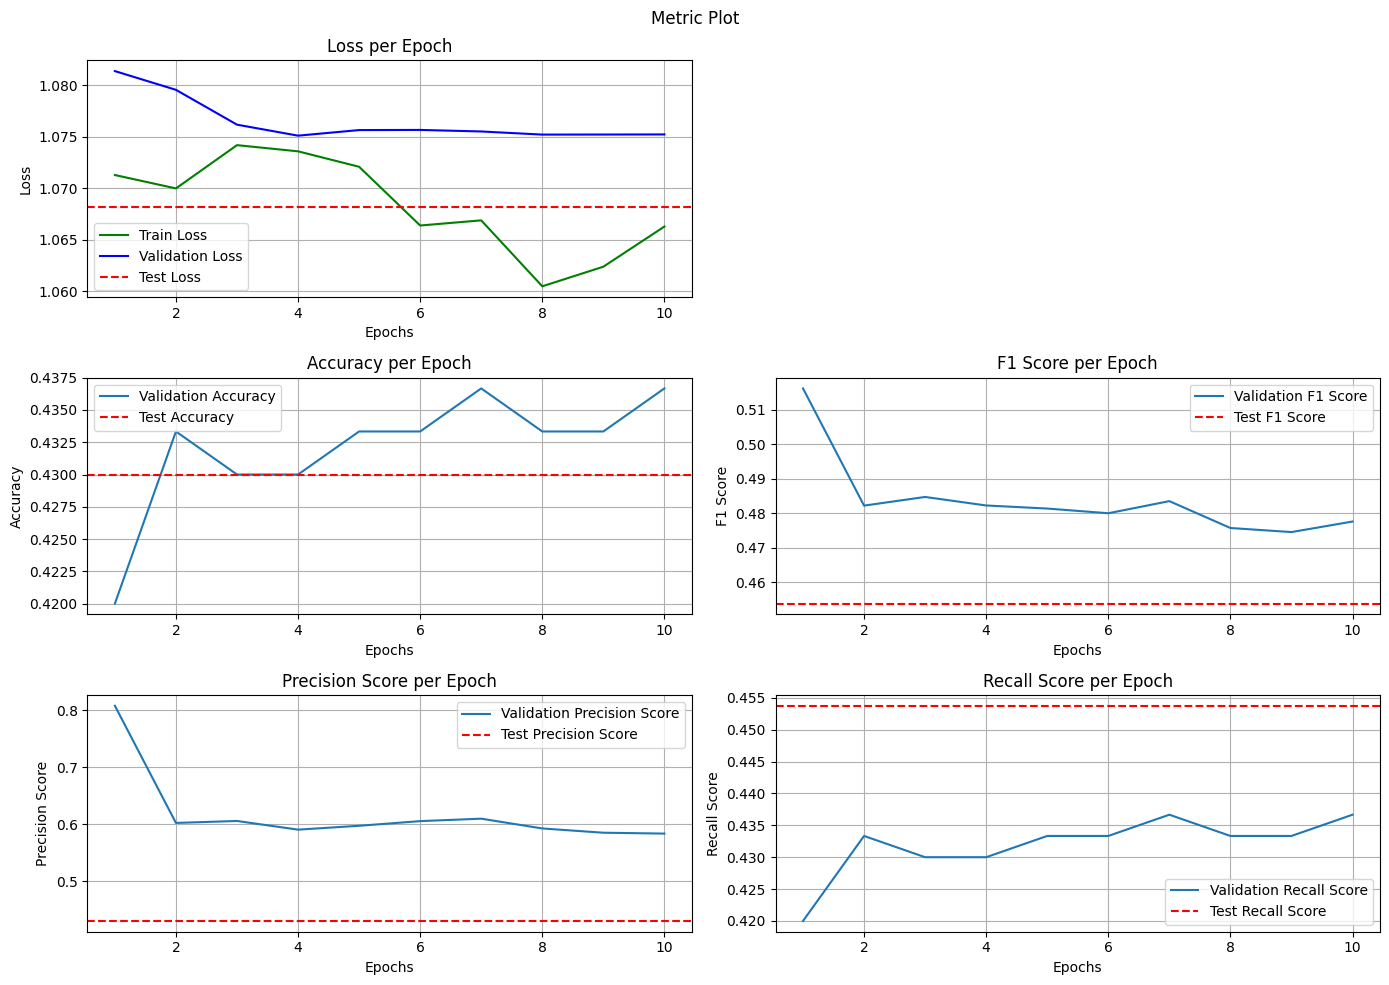

In [72]:
import matplotlib.pyplot as plt

def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []
    val_precision = []
    val_recall = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])
            if 'eval_precision' in log:
                val_precision.append(log['eval_precision'])
            if 'eval_recall' in log:
                val_recall.append(log['eval_recall'])

    test_loss = metrics['test_loss']
    test_accuracy = metrics['test_accuracy']
    test_f1 = metrics['test_f1']
    test_precision = metrics['test_accuracy']
    test_recall = metrics['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 10))

    # 손실 플롯
    plt.subplot(3, 2, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 2, 3)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 4)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.plot(epochs, val_precision, label='Validation Precision Score')
    plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision Score')
    plt.xlabel('Epochs')
    plt.ylabel('Precision Score')
    plt.title('Precision Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    plt.plot(epochs, val_recall, label='Validation Recall Score')
    plt.axhline(y=test_recall, color='r', linestyle='--', label='Test Recall Score')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')
    plt.title('Recall Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Metric Plot")
    plt.tight_layout()
    print("\n\n")

plotting()
plt.show()

In [89]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = count_trainable_parameters(model)
train_runtime_lst = trainer.state.log_history[-1]['train_runtime']

result_df = pd.DataFrame([metrics])
initial_result_df = pd.DataFrame([initial_metrics])

result_df = pd.concat([result_df, initial_result_df], axis=0)
result_df.index = ['trained_model_metrics','initial_metrics']
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']]

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
trained_model_metrics,1.068156,0.43,0.453753,592899,76.2918,0.8668
initial_metrics,1.068156,0.43,0.453753,592899,76.2918,0.8766


## [My Code] Conclusion